In [1]:
import os
import glob

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import ParameterDict

import torchvision
from torchvision import transforms

import kornia as K

import matplotlib.pyplot as plt
from PIL import Image

from AugmentationsDataset import *

from utils import plot_tensor, show_sample, learning_grid, create_loss_map

In [2]:
from config.rotation_config import *
# from config.brightness_config import *
# from config.shearX_config import *

In [3]:
source_transform = transforms.Compose([
    transforms.ToTensor()
])

target_augmentations = transforms.Compose([
    K.augmentation.container.ImageSequential(
        target_aug_constructor(**target_aug_constructor_args)
    )
])

target_transform = transforms.Compose([
    # transforms.ToTensor(),
    target_augmentations
])

In [4]:
glob_path = '../data/tiny-imagenet-200/train/*/images/*'
dataset = AugmentationsDataset(glob_path,
                               source_transform, target_transform,)

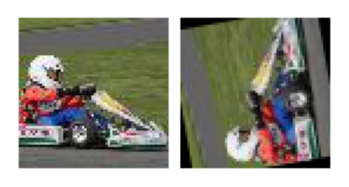

In [5]:
show_sample(dataset[0])

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [7]:
class AugmentationNetwork(nn.Module):
    def __init__(self, aug_constructor, learnable_params, aug_constructor_args, aug_bounds):
        super(AugmentationNetwork, self).__init__()
        self.aug_constructor = aug_constructor
        self.learnable_params = ParameterDict(learnable_params)
        self.aug_constructor_args = aug_constructor_args
        self.aug_bounds = aug_bounds
        
    def forward(self, x):
        learnable_clamped_params = {}
        if self.aug_bounds != (None,None):
            for param_name in self.learnable_params:
                learnable_clamped_params[param_name] = torch.clamp(self.learnable_params[param_name],
                                                                min=self.aug_bounds[0],
                                                                max=self.aug_bounds[1])
        else:
            learnable_clamped_params = self.learnable_params

        augmenter = K.augmentation.container.ImageSequential(
            self.aug_constructor(**learnable_clamped_params, **self.aug_constructor_args)
        )
        
        out = augmenter(x)
        return out

    

In [8]:
model = AugmentationNetwork(
    aug_constructor=training_aug_constructor,
    learnable_params=aug_learnable_params,
    aug_constructor_args=training_aug_constructor_args,
    aug_bounds=aug_bounds
)
model.to(device)

AugmentationNetwork(
  (learnable_params): ParameterDict(  (angle): Parameter containing: [torch.cuda.FloatTensor of size 1 (GPU 0)])
)

In [9]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

learnable_params.angle tensor([0.], device='cuda:0')


In [10]:
criterion = criterion_constructor(**criterion_constructor_args)
optimizer = optimizer_constructor(model.parameters(), **optimizer_constructor_args)
scheduler = scheduler_constructor(optimizer, **scheduler_constructor_args)

Adjusting learning rate of group 0 to 5.0000e+01.


In [11]:
losses = []
lrs = []
p_progress = {p_name: [] for p_name in aug_learnable_params_names}
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        source_images, target_images = data
        source_images, target_images = source_images.to(device), target_images.to(device)
        
        optimizer.zero_grad()

        output_images = model(source_images)
        loss = criterion(output_images, target_images)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        running_loss += loss.item()
        print_every = 10
        if i % print_every == print_every - 1:
            print(f'[Epoch: {epoch+1} | Batch: {i+1} | MSE Loss: {running_loss/print_every:.3f} | ', end='')
            print(f'{main_parameter_name}: {model.learnable_params[main_parameter_name].item()}]')
            running_loss = 0.0

            with torch.no_grad():
                model.to('cpu')
                img_dict = {
                    "source": dataset[0][0],
                    "model's output": model(dataset[0][0].unsqueeze(0)).squeeze(),
                    "target": dataset[0][1]
                }
                learning_grid(img_dict, save=f'{run_figures_dir}/epoch-{epoch+1:02}_batch-{i+1:05}.png')
                model.to(device)
        
        lrs.append(scheduler.get_last_lr())
        for p_name in model.learnable_params:
            p_progress[p_name].append(model.learnable_params[p_name].item())
        if use_scheduler:
            if i % scheduler_freq == scheduler_freq - 1 and i > scheduler_warmup:
                scheduler.step()


        if i == early_stopping:
            break

print('Finished Training.')

[Epoch: 1 | Batch: 10 | MSE Loss: 0.104 | angle: 11.617057800292969]
[Epoch: 1 | Batch: 20 | MSE Loss: 0.092 | angle: 25.299306869506836]
[Epoch: 1 | Batch: 30 | MSE Loss: 0.098 | angle: 36.038944244384766]
[Epoch: 1 | Batch: 40 | MSE Loss: 0.098 | angle: 45.73759078979492]
[Epoch: 1 | Batch: 50 | MSE Loss: 0.097 | angle: 55.47072982788086]
[Epoch: 1 | Batch: 60 | MSE Loss: 0.090 | angle: 67.12511444091797]
[Epoch: 1 | Batch: 70 | MSE Loss: 0.077 | angle: 82.05767822265625]
[Epoch: 1 | Batch: 80 | MSE Loss: 0.039 | angle: 102.90336608886719]
[Epoch: 1 | Batch: 90 | MSE Loss: 0.040 | angle: 116.1422348022461]
[Epoch: 1 | Batch: 100 | MSE Loss: 0.058 | angle: 116.43284606933594]
[Epoch: 1 | Batch: 110 | MSE Loss: 0.047 | angle: 105.8377456665039]
Adjusting learning rate of group 0 to 4.9988e+01.
[Epoch: 1 | Batch: 120 | MSE Loss: 0.023 | angle: 90.2090835571289]
Adjusting learning rate of group 0 to 4.9951e+01.
[Epoch: 1 | Batch: 130 | MSE Loss: 0.026 | angle: 104.85649108886719]
Adjusti

In [12]:
def bound_p(p, aug_bounds):
    bb = aug_bounds[0] # bottom bound
    ub = aug_bounds[1] # upper bound
    if bb and p < bb:
        return bb
    elif ub and p > ub:
        return ub
    return p

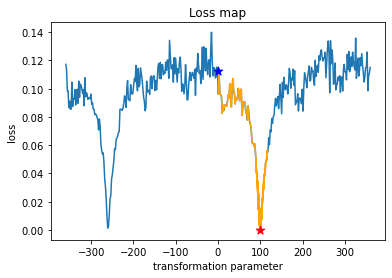

In [13]:
# loss map

loss_map = create_loss_map(AugmentationNetwork, training_aug_constructor, training_aug_constructor_args,
                           aug_learnable_params, main_parameter_name, 
                           aug_bounds, param_linspace, dataloader, criterion, save=run_name)
main_p_progress = p_progress[main_parameter_name]
main_p_progress = [bound_p(p, aug_bounds) for p in main_p_progress]
main_p_progress_losses = [loss_map[np.argmin([abs(p-pg) for p in param_linspace])] for pg in main_p_progress]
final_param = main_p_progress[-1]
final_param = np.argmin([abs(p-final_param) for p in param_linspace])
statring_point = init_param_val
statring_point = np.argmin([abs(p-statring_point) for p in param_linspace])
plt.plot(param_linspace, loss_map, zorder=2)
plt.scatter(param_linspace[statring_point], y=[loss_map[statring_point]], marker='*', c='b', s=80, zorder=4)
plt.scatter(param_linspace[final_param], y=[loss_map[final_param]], marker='*', c='r', s=80, zorder=4)
plt.plot(main_p_progress, main_p_progress_losses, c='orange', zorder=3)
plt.title('Loss map')
plt.xlabel('transformation parameter')
plt.ylabel('loss')
plt.savefig(f'{run_figures_dir}/results/loss_map.png')

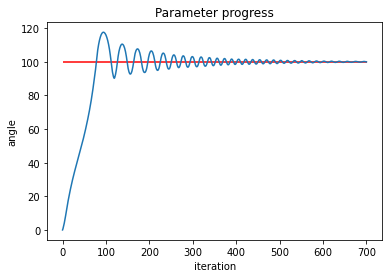

In [14]:
for p_name in p_progress:
    plt.plot(p_progress[p_name], zorder=7)
    plt.hlines(y=[target_aug_constructor_args[p_name][0]], xmin=[0], xmax=[len(p_progress[p_name])], color='r',zorder=5)
    plt.xlabel('iteration')
    plt.ylabel(f'{p_name}')
    plt.title('Parameter progress')
    plt.savefig(f'{run_figures_dir}/results/parameter_progress__{p_name}.png')

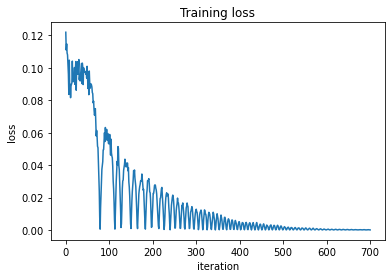

In [15]:
plt.plot(losses)
plt.title('Training loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.savefig(f'{run_figures_dir}/results/training_loss.png')

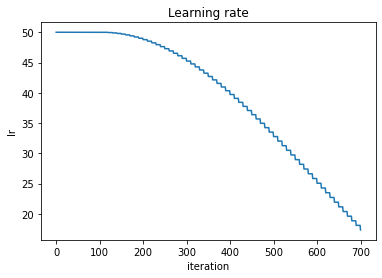

In [16]:
plt.plot(lrs)
plt.title('Learning rate')
plt.xlabel('iteration')
plt.ylabel('lr')
plt.savefig(f'{run_figures_dir}/results/learning_rate.png')

In [17]:
num_frames = 40
# filepaths
fp_in = f"{run_figures_dir}/epoch-*"
fp_out = run_gif_name

imgs = iter([Image.open(f) for f in sorted(glob.glob(fp_in))][:num_frames])
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=75, loop=0)